In [50]:
# Import packages
import os
import glob
import shutil
import plotnine

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from plotnine import ggplot
from plotnine import aes 
from plotnine import geom_line
from plotnine import labs

In [51]:
# Reproducibility
np.random.seed(478)
tf.random.set_seed(478)

In [52]:
# Read in data from .csv files
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')

# Convert Pandas dataframes to valid Numpy arrays
def convert(X):
    data = np.empty((X.shape[0], 28, 28, 1))
    for i in range(X.shape[0]):
        img = np.array(X.iloc[i, :]).reshape((28, 28, 1))
        data[i] = img
    return(np.array(data))

# Define training set
X_train = convert(train.drop('label', axis = 1)) / 255
y_train = train['label']

# Define testing set
X_test = convert(test) / 255

In [53]:
# Define model architecture
model = keras.Sequential([
    layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = [28, 28, 1]),
    layers.MaxPool2D(),

    layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu'),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(units = 10, activation = tf.nn.softmax)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                16010     
Total params: 34,826
Trainable params: 34,826
Non-trainable params: 0
__________________________________________________

In [54]:
# Define number of training epochs
EPOCHS = 20

# Compile model
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

# Train model with 75/25 training/validation split
trained = model.fit(
    X_train,
    y_train,
    epochs = EPOCHS,
    validation_split = .25
)

Epoch 1/20
985/985 [==============================] - 10s 10ms/step - loss: 0.5056 - accuracy: 0.8443 - val_loss: 0.0772 - val_accuracy: 0.9757
Epoch 2/20
985/985 [==============================] - 10s 10ms/step - loss: 0.0743 - accuracy: 0.9769 - val_loss: 0.0894 - val_accuracy: 0.9727
Epoch 3/20
985/985 [==============================] - 10s 10ms/step - loss: 0.0503 - accuracy: 0.9840 - val_loss: 0.0567 - val_accuracy: 0.9816
Epoch 4/20
985/985 [==============================] - 10s 10ms/step - loss: 0.0355 - accuracy: 0.9883 - val_loss: 0.0451 - val_accuracy: 0.9861
Epoch 5/20
985/985 [==============================] - 10s 10ms/step - loss: 0.0312 - accuracy: 0.9902 - val_loss: 0.0429 - val_accuracy: 0.9870
Epoch 6/20
985/985 [==============================] - 10s 10ms/step - loss: 0.0245 - accuracy: 0.9921 - val_loss: 0.0450 - val_accuracy: 0.9878
Epoch 7/20
985/985 [==============================] - 10s 10ms/step - loss: 0.0196 - accuracy: 0.9940 - val_loss: 0.0502 - val_accuracy:

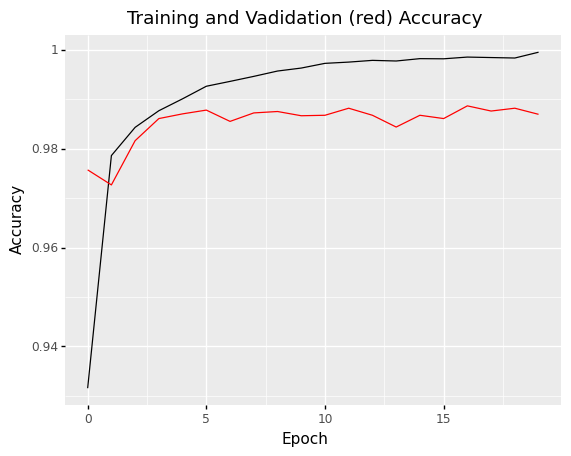

<ggplot: (8773251675853)>

In [55]:
# Plot training and validation accuracy
(
    ggplot() 
    + geom_line(aes(range(EPOCHS), trained.history['accuracy']))
    + geom_line(aes(range(EPOCHS), trained.history['val_accuracy']), color = 'red')
    + labs(title='Training and Vadidation (red) Accuracy', x='Epoch', y='Accuracy')
)

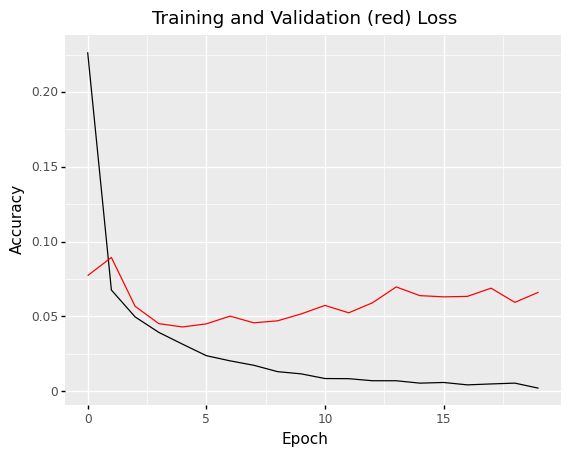

<ggplot: (8773251647467)>

In [56]:
# Plot training and validation loss
(
    ggplot()
    + geom_line(aes(range(EPOCHS), trained.history['loss']))
    + geom_line(aes(range(EPOCHS), trained.history['val_loss']), color = 'red')
    + labs(title='Training and Validation (red) Loss', x='Epoch', y='Accuracy')
)

In [57]:
# Generate competition preedictions based on test set
pred = pd.DataFrame(model.predict(X_test)).idxmax(axis = 1)
pred.head()

0    2
1    0
2    9
3    9
4    3
dtype: int64